In [18]:
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time

import sklearn
import sklearn_crfsuite
import scipy.stats
import math, string, re
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn_crfsuite import CRF
from nltk.tokenize import word_tokenize
from nltk.tag.util import untag

import ast
from ast import literal_eval

import jieba 
from hanziconv import HanziConv

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer
from operator import add

In [19]:
# read in the seniors previous training data 
df = pd.read_csv("seniors_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318 entries, 0 to 6317
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagged  6318 non-null   object
dtypes: object(1)
memory usage: 49.5+ KB


In [20]:
df.head()

,tagged
0,"[('In', 'ADP'), ('a', 'DET'), ('webinar', 'NOU..."
1,"[('I', 'PRON'), ('think', 'VERB'), ('that', 'D..."
2,"[('Goooood', 'X'), (',', 'PUNCT'), ('very', 'A..."
3,"[('!', 'PUNCT'), ('nice', 'ADJ'), ('to', 'ADP'..."
4,"[('item', 'NOUN'), ('with', 'ADP'), ('nice', '..."


In [21]:
def convert_string2_list(text):
    return ast.literal_eval(str(text))

In [22]:
def features(sentence, index):
    # """ sentence: [w1, w2, ...], index: the index of the word """
    
    feature_set =  {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'prefix-4': sentence[index][:4],
        'prefix-5': sentence[index][:5],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'suffix-4': sentence[index][-4:],
        'suffix-5': sentence[index][-5:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'prev2_word': '' if index == 0 else sentence[index - 2],
        'next2_word': '' if index == len(sentence) - 2 or index == len(sentence) - 1  else sentence[index + 2],
        'prev3_word': '' if index == 0 else sentence[index - 3],
        'next3_word': '' if index == len(sentence) - 2 or index == len(sentence) - 1  or index == len(sentence) - 3  else sentence[index + 3],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
        'natural_number': (re.findall(r'^[0-9]+', sentence[index])),
        'initcaps' : (re.findall(r'^[A-Z]\w+', sentence[index])),
        'initcapsalpha': (re.findall(r'^[A-Z][a-z]\w+', sentence[index])),
        'word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', sentence[index].lower()),
        'word.ispunctuation': (sentence[index] in string.punctuation)
    }
    
    if index <= 0:
        feature_set['BOS'] = True
    
    if index > len(sentence)-1:
        feature_set['EOS'] = True
        
    return feature_set

In [23]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
 
    for tagged in tagged_sentences:
        X.append([features(untag(tagged), index) for index in range(len(tagged))])
        y.append([tag for _, tag in tagged])
 
    return X, y

In [24]:
def pos_tag(sentence, model):
    sentence = sentence_splitter(sentence)
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, model.predict([sentence_features])[0]))

In [25]:
def sentence_splitter(sentence):
    result = []
    sents = word_tokenize(sentence)
    for s in sents:
        if re.findall(r'[\u4e00-\u9fff]+', s):
            s = HanziConv.toSimplified(s)
            result = result + list(jieba.cut(s, cut_all=False))
        else:
            result.append(s)
    return result

In [26]:
# Split the dataset for training and testing
data = df.tagged.apply(convert_string2_list)
data = data.to_list()

In [27]:
cutoff = int(.80 * len(data))
training_sentences = data[:cutoff]
test_sentences = data[cutoff:]

In [28]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(test_sentences)

In [29]:
print(len(X_train))     
print(len(X_test))         

5054
1264


In [65]:
X_train[0:10]

[[{'word': 'In',
   'is_first': True,
   'is_last': False,
   'is_capitalized': True,
   'is_all_caps': False,
   'is_all_lower': False,
   'prefix-1': 'I',
   'prefix-2': 'In',
   'prefix-3': 'In',
   'prefix-4': 'In',
   'prefix-5': 'In',
   'suffix-1': 'n',
   'suffix-2': 'In',
   'suffix-3': 'In',
   'suffix-4': 'In',
   'suffix-5': 'In',
   'prev_word': '',
   'next_word': 'a',
   'prev2_word': '',
   'next2_word': 'webinar',
   'prev3_word': '',
   'next3_word': 'last',
   'has_hyphen': False,
   'is_numeric': False,
   'capitals_inside': False,
   'natural_number': [],
   'initcaps': ['In'],
   'initcapsalpha': [],
   'word.stemmed': 'in',
   'word.ispunctuation': False,
   'BOS': True},
  {'word': 'a',
   'is_first': False,
   'is_last': False,
   'is_capitalized': False,
   'is_all_caps': False,
   'is_all_lower': True,
   'prefix-1': 'a',
   'prefix-2': 'a',
   'prefix-3': 'a',
   'prefix-4': 'a',
   'prefix-5': 'a',
   'suffix-1': 'a',
   'suffix-2': 'a',
   'suffix-3': 'a',

# Trying to implement Karl Stratos Mini Tagger Approach

# Trying to split things out JIAYOU WINNIE

In [259]:
FRONT_BUFFER_SYMBOL = "_START_"  # For sentence boundaries
END_BUFFER_SYMBOL = "_END_"  # For sentence boundaries
UNKNOWN_SYMBOL = "<?>"   # For unknown observation types at test time

global SPELLING_FEATURE_CACHE
SPELLING_FEATURE_CACHE = {}

In [260]:
def clear_spelling_feature_cache():
    """Clears the global spelling feature cache."""
    global SPELLING_FEATURE_CACHE
    SPELLING_FEATURE_CACHE = {}
    
def get_word(word_sequence, position):
    """Gets the word at the specified position."""
    if position < 0:
        return FRONT_BUFFER_SYMBOL
    elif position >= len(word_sequence):
        return END_BUFFER_SYMBOL
    else:
        return word_sequence[position]

def is_capitalized(word):
    """Is the word capitalized?"""
    return word[0].isupper()

def get_prefix(word, length):
    """Gets a padded prefix of the word up to the given length."""
    prefix = ""
    for i in range(length):
        if i < len(word):
            prefix += word[i]
        else:
            prefix += "*"
    return prefix

def get_suffix(word, length):
    """Gets a padded suffix of the word up to the given length."""
    suffix = ""
    for i in range(length):
        if i < len(word):
            suffix = word[-i-1] + suffix
        else:
            suffix = "*" + suffix
    return suffix

def is_all_nonalphanumeric(word):
    """Is the word all nonalphanumeric?"""
    for char in word:
        if char.isalnum():
            return False
    return True

def is_float(word):
    """Can the word be converted to a float (i.e., numeric value)?"""
    try:
        float(word)
        return True
    except ValueError:
        return False

def spelling_features(word, relative_position):
    """
    Extracts spelling features about the given word. Also considers the word's
    relative position.
    """
    if not (word, relative_position) in SPELLING_FEATURE_CACHE:
        features = {}
        features["word({0})={1}".format(relative_position, word)] = 1
        features['is_capitalized({0})={1}'.format(
                relative_position, is_capitalized(word))] = 1
        for length in range(1, 5):
            features["prefix{0}({1})={2}".format(
                    length, relative_position, get_prefix(word, length))] = 1
            features["suffix{0}({1})={2}".format(
                    length, relative_position, get_suffix(word, length))] = 1
        features["is_all_nonalphanumeric({0})={1}".format(
                relative_position, is_all_nonalphanumeric(word))] = 1
        features["is_float({0})={1}".format(
                relative_position, is_float(word))] = 1
        SPELLING_FEATURE_CACHE[(word, relative_position)] = features

    # Return a copy so that modifying that object doesn't modify the cache.
    return SPELLING_FEATURE_CACHE[(word, relative_position)].copy()

def get_baseline_features(word_sequence, position): 
    word = get_word(word_sequence, position)
    word_left1 = get_word(word_sequence, position - 1)
    word_left2 = get_word(word_sequence, position - 2)
    word_right1 = get_word(word_sequence, position + 1)
    word_right2 = get_word(word_sequence, position + 2)
    features = spelling_features(word, 0)
    features["word(-1)={0}".format(word_left1)] = 1
    features["word(-2)={0}".format(word_left2)] = 1
    features["word(+1)={0}".format(word_right1)] = 1
    features["word(+2)={0}".format(word_right2)] = 1
    
    return features

In [ ]:
def get_bitstring_features(word_sequence, position, bitstring_dictionary):
    """
    Bit string features: baseline features + bit strings of current, left, and
    right words.
    """
    # Compute the baseline feature vector.
    features = get_baseline_features(word_sequence, position)

    # Add the bit string features.
    word = word_sequence[position]  # current word
    if word in bitstring_dictionary:
        word_bitstring = bitstring_dictionary[word]
    else:
        word_bitstring = bitstring_dictionary[UNKNOWN_SYMBOL]
    for i in range(1, len(word_bitstring) + 1):
        features["bitstring(0)_prefix({0})={1}".format(
                i, word_bitstring[:i])] = 1
    features["bitstring(0)_all={0}".format(word_bitstring)] = 1

    if position > 0:
        word = word_sequence[position - 1]  # word to the left
        if word in bitstring_dictionary:
            word_bitstring = bitstring_dictionary[word]
        else:
            word_bitstring = bitstring_dictionary[UNKNOWN_SYMBOL]
        for i in range(1, len(word_bitstring) + 1):
            features["bitstring(-1)_prefix({0})={1}".format(
                    i, word_bitstring[:i])] = 1
        features["bitstring(-1)_all={0}".format(word_bitstring)] = 1

    if position < len(word_sequence) - 1:
        word = word_sequence[position + 1]  # word to the right
        if word in bitstring_dictionary:
            word_bitstring = bitstring_dictionary[word]
        else:
            word_bitstring = bitstring_dictionary[UNKNOWN_SYMBOL]
        for i in range(1, len(word_bitstring) + 1):
            features["bitstring(+1)_prefix({0})={1}".format(
                    i, word_bitstring[:i])] = 1
        features["bitstring(+1)_all={0}".format(word_bitstring)] = 1

    return features

In [261]:
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

In [363]:
print("__map_label_str2num", __map_label_str2num)
print("__map_label_num2str", __map_label_num2str)
print("__map_feature_str2num", __map_feature_str2num)
print("__map_feature_num2str", __map_feature_num2str)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [263]:
def __get_label(label):
    """
    When this function is being called, it will append a new label into the dictionary.
    If the label already exist in the function, it will just return the label in integer value. 
    Universal tagset will return 1-12. 
    """
    if not label in __map_label_str2num:
        label_number = len(__map_label_str2num) + 1  # index from 1
        __map_label_str2num[label] = label_number
        __map_label_num2str[label_number] = label
    return __map_label_str2num[label]

In [382]:
# EDIT HERE TO CHANGE THE TEMPLATE TO EXTRACT FEATURES
feature_template = "baseline" 
# feature_template = "embedding" 
# feature_template = "bitstring" 

In [265]:
__word_embedding = None
__word_bitstring = None

In [266]:
def num_feature_types():
    return len(__map_feature_str2num)

def get_feature_string(feature_number):
    return __map_feature_num2str[feature_number]

def get_label_string(label_number):
    return __map_label_num2str[label_number]

def get_feature_number(feature_string):
    return __map_feature_str2num[feature_string]

def get_label_number(label_string):
    return __map_label_str2num[label_string]

In [267]:
def __get_features(observation_sequence, position):
    if feature_template == "baseline":
        raw_features = get_baseline_features(observation_sequence, position)
    elif feature_template == "embedding":
        assert __word_embedding is not None
        raw_features = get_embedding_features(observation_sequence, position, __word_embedding)
    elif feature_template == "bitstring":
        assert __word_bitstring is not None
        raw_features = get_bitstring_features(observation_sequence, position, __word_bitstring)
    else:
        raise Exception("Unsupported feature template {0}".format(feature_template))
        
    numeric_features = {}
    for raw_feature in raw_features:
        
        if not raw_feature in __map_feature_str2num:
            feature_number = len(__map_feature_str2num) + 1
            __map_feature_str2num[raw_feature] = feature_number
            __map_feature_num2str[feature_number] = raw_feature
            
        numeric_features[__map_feature_str2num[raw_feature]] = raw_features[raw_feature]
        
    return numeric_features

In [268]:
def extract_features(sequence_data, extract_all, skip_list): 
    label_list = []
    features_list = []
    location_list = []
    
    for sequence_num, (observation_sequence, label_sequence) in enumerate(sequence_data):
        for position, label in enumerate(label_sequence):
            
            if skip_list and skip_list[sequence_num][position]:
                continue 
                
            if (not label is None) or extract_all:
                label_list.append(__get_label(label))
                features_list.append(__get_features(observation_sequence, position))
                location_list.append((sequence_num, position))
                
    return label_list, features_list, location_list

In [269]:
sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']],
                  [['This', 'is', 'me'],['DET','AUX','PRON']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN',None,  'ADJ', 'DET', 'NOUN']]]
# data_train = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]
# sequence_pairs = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]

In [270]:
label_list, features_list, _ = extract_features(sequence_pairs, False, [])

In [271]:
label_list

[1, 2, 3, 4, 5, 4, 2, 6]

In [272]:
features_list

[{1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  9: 1,
  10: 1,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  16: 1},
 {17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1,
  24: 1,
  25: 1,
  26: 1,
  11: 1,
  12: 1,
  27: 1,
  14: 1,
  28: 1,
  29: 1},
 {30: 1,
  18: 1,
  31: 1,
  4: 1,
  32: 1,
  33: 1,
  34: 1,
  35: 1,
  36: 1,
  37: 1,
  11: 1,
  12: 1,
  38: 1,
  39: 1,
  40: 1,
  41: 1},
 {42: 1,
  18: 1,
  43: 1,
  4: 1,
  44: 1,
  45: 1,
  46: 1,
  47: 1,
  48: 1,
  49: 1,
  11: 1,
  12: 1,
  50: 1,
  51: 1,
  52: 1,
  53: 1},
 {54: 1,
  18: 1,
  31: 1,
  55: 1,
  56: 1,
  57: 1,
  58: 1,
  59: 1,
  60: 1,
  61: 1,
  11: 1,
  12: 1,
  62: 1,
  63: 1,
  64: 1,
  53: 1},
 {65: 1,
  2: 1,
  66: 1,
  20: 1,
  67: 1,
  22: 1,
  68: 1,
  69: 1,
  70: 1,
  71: 1,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  72: 1},
 {17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1,
  24: 1,
  25: 1,
  26: 1,
  11: 1,
  12: 1,
  73: 1,
  14: 1,
  74: 1,
  53: 1

In [273]:
_

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2)]

In [274]:
len(features_list)

8

In [275]:
import argparse
import collections
import datetime
import math
import numpy
import os
import pickle
import random
import subprocess
import sys
import time

path = "liblinear-1.96/python"
sys.path.append(os.path.abspath(path))

import liblinearutil

In [276]:
# print("{0} labeled instances (out of {1})".format(len(label_list), data_train.num_instances))
# print("{0} label types".format(len(data_train.label_count)))
# print("{0} observation types".format(len(data_train.observation_count)))
# print("\"{0}\" feature template".format(self.__feature_extractor.feature_template))
# print("{0} feature types".format(self.__feature_extractor.num_feature_types()))

In [277]:
print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))
print("{0} observation types".format(len(sequence_pairs[0][0])))

8 labeled instances (out of 8)
8 label types
5 observation types


In [278]:
problem = liblinearutil.problem(label_list, features_list)

In [279]:
__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

In [280]:
data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN']]]
# data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', '', 'VERB', 'DET', 'NOUN']]]

In [281]:
_, acc = predict(data_dev)

[[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN']]]
[4, 5, 7, 4, 5]
[{84: 1, 2: 1, 66: 1, 4: 1, 67: 1, 45: 1, 85: 1, 86: 1, 87: 1, 88: 1, 11: 1, 12: 1, 13: 1, 14: 1, 89: 1, 90: 1}, {91: 1, 18: 1, 92: 1, 55: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 11: 1, 12: 1, 99: 1, 14: 1, 100: 1, 101: 1}, {102: 1, 18: 1, 103: 1, 4: 1, 104: 1, 33: 1, 105: 1, 106: 1, 107: 1, 108: 1, 11: 1, 12: 1, 109: 1, 110: 1, 111: 1, 112: 1}, {113: 1, 18: 1, 103: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 11: 1, 12: 1, 121: 1, 122: 1, 123: 1, 53: 1}, {124: 1, 18: 1, 125: 1, 114: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 11: 1, 12: 1, 132: 1, 133: 1, 64: 1, 53: 1}]
[4.0, 2.0, 3.0, 4.0, 5.0]
60.0
[[-0.3567717329132573, -0.7695453806572491, -0.6480543293489829, 0.1442477438021597, -0.7720423985213759, -0.6605928223149127], [-0.4623311890539694, -0.3093712967727721, -0.48958499004204875, -0.38048493486315904, -0.3295724196854575, -0.5295406300247584], [-0.4754

In [282]:
print("predicted labels: ", _)
print(acc)

predicted labels:  ['DET', 'AUX', 'ADJ', 'DET', 'NOUN']
60.0


In [283]:
data_dev = [[['I', 'am', 'Winnie'], ['PRON', 'AUX', 'PROPN']]]
_, acc = predict(data_dev)

[[['I', 'am', 'Winnie'], ['PRON', 'AUX', 'PROPN']]]
[6, 2, 1]
[{134: 1, 2: 1, 135: 1, 136: 1, 137: 1, 138: 1, 139: 1, 140: 1, 141: 1, 142: 1, 11: 1, 12: 1, 13: 1, 14: 1, 143: 1, 144: 1}, {145: 1, 18: 1, 103: 1, 146: 1, 147: 1, 148: 1, 149: 1, 150: 1, 151: 1, 152: 1, 11: 1, 12: 1, 153: 1, 14: 1, 154: 1, 53: 1}, {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 155: 1, 156: 1, 64: 1, 53: 1}]
[4.0, 2.0, 1.0]
66.66666666666667
[[-0.17144611502594054, -0.4360030982285758, -0.5238695914662893, -0.15182803422128668, -0.4978469290237178, -0.534583266292751], [-0.5363189021357877, -0.31050222032100344, -0.5857139764825223, -0.36715071773538116, -0.451599115702811, -0.4826935422431142], [0.5640609517723756, -0.9097520645855963, -0.9250022236486652, -1.0284521834273177, -0.6683649454079148, -0.6242250494900458]]
Prediction time: 0:00:01
Per-instance accuracy: 66.667%


In [284]:
print("predicted labels: ", _)
print(acc)

predicted labels:  ['DET', 'AUX', 'PROPN']
66.66666666666667


# About prediction (function)

In [380]:
def predict(data_test):
    # print(data_test)
    start_time = time.time()
    [label_list, features_list, _] = extract_features(data_test, True, [])
    print(label_list)
    print(features_list)
    
    pred_labels, (acc, _, _), _ = liblinearutil.predict(label_list, features_list, __liblinear_model, "-q")
    
    print(pred_labels)
    print(acc)
    print(_)
    
    
    num_seconds = int(math.ceil(time.time() - start_time))
    print("Prediction time: {0}".format(str(datetime.timedelta(seconds=num_seconds))))
            
    print("Per-instance accuracy: {0:.3f}%".format(acc))
    
    for i, label in enumerate(pred_labels):
        pred_labels[i] = get_label_string(label)
    return pred_labels, acc

In [55]:
def train(label_list, features_list):
    """Trains Minitagger on the given data."""
    start_time = time.time()
  
    problem = liblinearutil.problem(label_list, features_list)
    __liblinear_model = \
        liblinearutil.train(problem, liblinearutil.parameter("-q"))
      
    quiet = False
    if not quiet:
        num_seconds = int(math.ceil(time.time() - start_time))
        print("Training time: {0}".format(
            str(datetime.timedelta(seconds=num_seconds))))
        if features_list is not None:
            quiet_value = quiet
            quiet = True
            _, acc = predict(label_list, features_list)
            quiet = quiet_value
            print("Dev accuracy: {0:.3f}%".format(acc))


In [352]:
# def predict(label_list, features_list):
#     start_time = time.time()

#         # Extract features (on all instances, labeled or unlabeled) and pass
#         # them to liblinear for prediction.
#     pred_labels, (acc, _, _), _ = \
#         liblinearutil.predict(label_list, features_list,
#                                 __liblinear_model, "-q")
#     quiet = False
#     if not quiet:
#         num_seconds = int(math.ceil(time.time() - start_time))
        
#         print("Prediction time: {0}".format(str(datetime.timedelta(seconds=num_seconds))))


#         # Convert predicted labels from integer IDs to strings.
#     for i, label in enumerate(pred_labels):
#         pred_labels[i] == label
#     return pred_labels, acc


# BREAKLINE 
## I am thinking to convert the dataset that we have into training testing and observe the performance
### using the finalize data have been created (penn treebank + xyyx + andrew)

In [285]:
import pandas as pd

In [286]:
df = pd.read_csv("train.csv")

In [287]:
df.head()

,tagged
0,"[('Its', 'DET'), ('fanciful', 'ADJ'), ('office..."
1,"[('Columbia', 'PROPN'), ('wo', 'VERB'), (""n't""..."
2,"[('谢谢', 'VERB'), ('卖家', 'NOUN'), ('，', 'PUNCT'..."
3,"[('--', 'PUNCT'), ('In', 'ADP'), ('Britain', '..."
4,"[('Personal', 'ADJ'), ('computer', 'NOUN'), ('..."


In [292]:
def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
data = data.to_list()

# train test split 
cutoff = int(.80 * len(data))
training_sentences = data[:cutoff]
test_sentences = data[cutoff:]

In [321]:
# all these data are in the format of listof tuple
# a function to change them into list of list is required 

def convert_listoftuples_to_listoflists(listoftuples):
    training_data = []
    for each_sentences in listoftuples: 
        observation_list = []
        label_list = []
        for i in each_sentences:
            observation = i[0]
            observation_list.append(observation)
            label = i[1]
            label_list.append(label)
        sentence_list = [observation_list,label_list]
        training_data.append(sentence_list)
    return training_data

In [322]:
data_train = convert_listoftuples_to_listoflists(training_sentences)

In [323]:
data_dev = convert_listoftuples_to_listoflists(test_sentences)

In [326]:
# rese4t all these values
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

In [327]:
label_list, features_list, _ = extract_features(data_train, False, [])

In [329]:
len(features_list)

78342

In [330]:
len(label_list)

78342

In [333]:
print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))

78342 labeled instances (out of 78342)
78342 label types


In [334]:
problem = liblinearutil.problem(label_list, features_list)

In [335]:
__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

In [338]:
_, acc = predict(data_dev)

Prediction time: 0:00:01
Per-instance accuracy: 89.972%


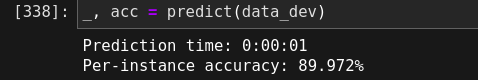

### using baselines feature and baseline training
## should do some ammendment in the code so that can get all the performance 

In [349]:
import pandas as pd
df = pd.read_csv("train_latest.csv")
df.head()
def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
data = data.to_list()

# train test split 
cutoff = int(.80 * len(data))
training_sentences = data[:cutoff]
test_sentences = data[cutoff:]

# all these data are in the format of listof tuple
# a function to change them into list of list is required 

def convert_listoftuples_to_listoflists(listoftuples):
    training_data = []
    for each_sentences in listoftuples: 
        observation_list = []
        label_list = []
        for i in each_sentences:
            observation = i[0]
            observation_list.append(observation)
            label = i[1]
            label_list.append(label)
        sentence_list = [observation_list,label_list]
        training_data.append(sentence_list)
    return training_data

data_train = convert_listoftuples_to_listoflists(training_sentences)
data_dev = convert_listoftuples_to_listoflists(test_sentences)

# rese4t all these values
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

label_list, features_list, _ = extract_features(data_train, False, [])

print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))

problem = liblinearutil.problem(label_list, features_list)

__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

_, acc = predict(data_dev)

109879 labeled instances (out of 109879)
109879 label types
Prediction time: 0:00:01
Per-instance accuracy: 82.617%


In [350]:
import pandas as pd
df = pd.read_csv("train_latest.csv")
df.head()
def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
data = data.to_list()

# train test split 
cutoff = int(.80 * len(data))
training_sentences = data[:cutoff]
test_sentences = data[cutoff:]

# all these data are in the format of listof tuple
# a function to change them into list of list is required 

def convert_listoftuples_to_listoflists(listoftuples):
    training_data = []
    for each_sentences in listoftuples: 
        observation_list = []
        label_list = []
        for i in each_sentences:
            observation = i[0]
            observation_list.append(observation)
            label = i[1]
            label_list.append(label)
        sentence_list = [observation_list,label_list]
        training_data.append(sentence_list)
    return training_data

data_train = convert_listoftuples_to_listoflists(training_sentences)
data_dev = convert_listoftuples_to_listoflists(test_sentences)

# rese4t all these values
__map_label_str2num = {}
__map_label_num2str = {}
__map_feature_str2num = {}
__map_feature_num2str = {}

label_list, features_list, _ = extract_features(data_train, False, [])

print("{0} labeled instances (out of {1})".format(len(label_list), len(features_list)))
print("{0} label types".format(len(label_list)))

problem = liblinearutil.problem(label_list, features_list)

__liblinear_model = liblinearutil.train(problem, liblinearutil.parameter("-q"))

_, acc = predict(data_dev)

79881 labeled instances (out of 79881)
79881 label types
Prediction time: 0:00:02
Per-instance accuracy: 96.196%


In [351]:
import pandas as pd
df = pd.read_csv("test_latest.csv")

def convert_string2_list(text):
    return ast.literal_eval(str(text))

data = df.tagged.apply(convert_string2_list)
test_sentences = data.to_list()

data_test = convert_listoftuples_to_listoflists(test_sentences)

_, acc = predict(data_test)

Prediction time: 0:00:01
Per-instance accuracy: 82.177%


# Testing on new sentences 


In [371]:
sample = ["She sells seashells on the seashore.", "I love planting."]

In [372]:
from nltk.tokenize import sent_tokenize, word_tokenize

def convert_data(sentences):
    """convert sentence into the list of list of list format"""
    sentences_list = word_tokenize(sentences)
    return sentences_list
    

In [373]:
data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN']]]
# data_dev = [[['The', 'rabbit', 'ate', 'a', 'zebra'], ['DET', '', 'VERB', 'DET', 'NOUN']]]

In [374]:
def predict_output(data_test):

    [label_list, features_list, _] = extract_features(data_test, True, [])

    pred_labels, (acc, _, _), _ = liblinearutil.predict(label_list, features_list, __liblinear_model, "-q")
    
    for i, label in enumerate(pred_labels):
        pred_labels[i] = get_label_string(label)
    return pred_labels, acc

In [375]:
predict_output([['I', 'am', 'happy'],[None, None, None]])

ValueError: too many values to unpack (expected 2)

# ABOUT ACTIVE TRAINING 

It seems like the author doing margin-based active learning, least confidence consider as margin based?

In [345]:
data_train = [[['I', 'am', 'Winnie'], ['PRON', 'AUX', 'PROPN']]]

__skip_extraction = []
for _, label_sequence in data_train:
    __skip_extraction.append([False for _ in label_sequence])

In [346]:
def __make_data_from_locations(data_train, locations):
    """The locations value will be something like [(0,0), (0,2)] and so on"""
    
    selected_positions = collections.defaultdict(list)
    
    for (sequence_num, position) in locations: 
        selected_positions[sequence_num].append(position)
    
    sequence_list = []
    
    for sequence_num in selected_positions: 
        word_sequence, label_sequence = data_train[sequence_num]
        selected_labels = [None for _ in range(len(word_sequence))]
        
        for position in selected_positions[sequence_num]:
            selected_labels[position] = label_sequence[position]
            __skip_extraction[sequence_num][position] = True
        sequence_list.append([word_sequence, selected_labels])
    
    
    # made some changes in the returning value 
    # prolly put something like 
    return sequence_list

In [ ]:
# the train function will required again 
def train(label_list, features_list):
    """Trains Minitagger on the given data."""
    start_time = time.time()
  
    problem = liblinearutil.problem(label_list, features_list)
    __liblinear_model = \
        liblinearutil.train(problem, liblinearutil.parameter("-q"))
      
    quiet = False
    if not quiet:
        num_seconds = int(math.ceil(time.time() - start_time))
        print("Training time: {0}".format(
            str(datetime.timedelta(seconds=num_seconds))))
        if features_list is not None:
            quiet_value = quiet
            quiet = True
            _, acc = predict(label_list, features_list)
            quiet = quiet_value
            print("Dev accuracy: {0:.3f}%".format(acc))


In [ ]:
def __train_silently(data_selected):
    """Trains on the argument data in silent mode."""
    self.__feature_extractor.is_training = True  # Reset for training.
    quiet_value = self.quiet
    self.quiet = True
    self.train(data_selected, None)  # No need for development here.
    self.quiet = quiet_value

In [347]:
__make_data_from_locations(data_train, [(0,0)])

[[['I', 'am', 'Winnie'], ['PRON', None, None]]]

In [ ]:
def train_actively(data_train, data_dev):
    

In [ ]:
    def train_actively(self, data_train, data_dev):
        """Does margin-based active learning on the given data."""

    
        
        # Create an output directory.
        if os.path.exists(self.active_output_path):
            subprocess.check_output(["rm", "-rf", self.active_output_path])
        os.makedirs(self.active_output_path)
        logfile = open(os.path.join(self.active_output_path, "log"), "w")

        def __make_data_from_locations(locations):
            """
            Makes SequenceData out of a subset of data_train from given
            location=(sequence_num, position) pairs.
            """
            
            selected_positions = collections.defaultdict(list)
            for (sequence_num, position) in locations:
                selected_positions[sequence_num].append(position)
                

            sequence_list = []
            for sequence_num in selected_positions:

                word_sequence, label_sequence = \
                    data_train.sequence_pairs[sequence_num]
                
                selected_labels = [None for _ in range(len(word_sequence))]
          
                for position in selected_positions[sequence_num]:
                    selected_labels[position] = label_sequence[position]

                    # This example will not be selected again.
                    __skip_extraction[sequence_num][position] = True
                sequence_list.append((word_sequence, selected_labels))
             
            # print("sequence_list: ", sequence_list)
            
            selected_data = SequenceData(sequence_list)
            
            # print("selected_data: ", selected_data)
            return selected_data

        def __train_silently(data_selected):
            """Trains on the argument data in silent mode."""
            self.__feature_extractor.is_training = True  # Reset for training.
            quiet_value = self.quiet
            self.quiet = True
            self.train(data_selected, None)  # No need for development here.
            self.quiet = quiet_value

        def __interval_report(data_selected):
            # Only report at each interval.
            if data_selected.num_labeled_instances % \
                    self.active_output_interval != 0:
                return
#             print("------------------------")
#             print("now at __interval_report")
#             print("------------------------")
#             print("data_selected.num_labeled_instances", data_selected.num_labeled_instances)
#             print("self.active_output_interval", self.active_output_interval)
            
            # Test on the development data if we have it.
            if data_dev is not None:
                quiet_value = self.quiet
                self.quiet = True
                _, acc = self.predict(data_dev)
                self.quiet = quiet_value
                message = "{0} labels: {1:.3f}%".format(
                    data_selected.num_labeled_instances, acc)
                print(message)
                logfile.write(message + "\n")
                logfile.flush()

            # Output the selected labeled examples so far.
            file_name = os.path.join(
                self.active_output_path,
                "example" + str(data_selected.num_labeled_instances))
            with open(file_name, "w") as outfile:
                outfile.write(data_selected.__str__())

        # Compute the (active_seed_size) most frequent word types in data_train.
        sorted_wordcount_pairs = sorted(data_train.observation_count.items(),
                                        key=lambda type_count: type_count[1],
                                        reverse=True)
        
        # print("sorted_wordcount_pairs")
        # print(sorted_wordcount_pairs)
        
        seed_wordtypes = [wordtype for wordtype, _ in
                          sorted_wordcount_pairs[:self.active_seed_size]]
        
        # print("seed_wordtypes")
        # print(seed_wordtypes)

        # Select a random occurrence of each selected type for a seed example.
        occurring_locations = collections.defaultdict(list)
        
        
        for sequence_num, (observation_sequence, _) in \
                enumerate(data_train.sequence_pairs):
            print("sequence_num: ",sequence_num)
            print("observation_sequence: ", observation_sequence) # the words
            print("_: ", _) # the tag
            print("")
            
            for position, word in enumerate(observation_sequence):
                print("position: ", position)
                print("word1: ", word)
                
                if word in seed_wordtypes:
                    print("word2: ", word)
                    occurring_locations[word].append((sequence_num, position))
                print("")
                    
        print("")
        print("occurring_locations: ", occurring_locations)
        
        
        locations = [random.sample(occurring_locations[wordtype], 1)[0] for
                     wordtype in seed_wordtypes]
        
        print("locations: ", locations)
        
        
        data_selected = __make_data_from_locations(locations)
        print("\ndata_selected: ", data_selected)
        
        __train_silently(data_selected)  # Train for the first time.
        __interval_report(data_selected)
        
        
        print("testing on new case")
        print("------------------")
        print(len(locations))
        print(data_train.num_labeled_instances)
        print("------------------")
        
        count = 0
        while len(locations) < data_train.num_labeled_instances:
            # Make predictions on the remaining (i.e., not on the skip list)
            # labeled examples.
            [label_list, features_list, location_list] = \
                self.__feature_extractor.extract_features(\
                data_train, False, __skip_extraction)

            _, _, scores_list = \
                liblinearutil.predict(label_list, features_list,
                                      self.__liblinear_model, "-q")
            
            # right here, I need to know about the score list being compute
            # what is the score mean by here 
            # theory behind and later sort it 
            # choose it as a confidence pair or what??? 
            # since later train function is being called
            # how it is being train this time? 
            
            # Compute "confidence" of each prediction:
            #   max_{y} score(x,y) - max_{y'!=argmax_{y} score(x,y)} score(x,y')
            confidence_index_pairs = []
            
            for index, scores in enumerate(scores_list):
                sorted_scores = sorted(scores, reverse=True)

                # Handle the binary case: liblinear gives only 1 score whose
                # sign indicates the class (+ versus -).
                confidence = sorted_scores[0] - sorted_scores[1] \
                    if len(scores) > 1 else abs(scores[0])
                confidence_index_pairs.append((confidence, index))
            
            count +=1 
            print("count->",count)
            # Select least confident examples for next labeling.
            print("before sorting: ",confidence_index_pairs)
            confidence_index_pairs.sort()
            
            print("after sorting: ",confidence_index_pairs)
            print("confidence_index_pairs[:self.active_step_size]:", confidence_index_pairs[:self.active_step_size])
            
            for _, index in confidence_index_pairs[:self.active_step_size]:
                print(_)
                print(index)
                print("location_list[index]", location_list[index])
                locations.append(location_list[index])
            
            print("locations: ", locations)
            data_selected = __make_data_from_locations(locations)
            
            __train_silently(data_selected)  # Train from scratch.
            __interval_report(data_selected)
            
            if count==1:
                break

        logfile.close()

# feature extraction

https://cetinsamet.medium.com/part-of-speech-pos-tagging-8af646a3d5bb

In [367]:
def __get_features(observation_sequence, position):
    if feature_template == "baseline":
        raw_features = get_baseline_features(observation_sequence, position)
    elif feature_template == "embedding":
        assert __word_embedding is not None
        raw_features = get_embedding_features(observation_sequence, position, __word_embedding)
    elif feature_template == "bitstring":
        assert __word_bitstring is not None
        raw_features = get_bitstring_features(observation_sequence, position, __word_bitstring)
    else:
        raise Exception("Unsupported feature template {0}".format(feature_template))
        
    numeric_features = {}
    for raw_feature in raw_features:
        
        if not raw_feature in __map_feature_str2num:
            feature_number = len(__map_feature_str2num) + 1
            __map_feature_str2num[raw_feature] = feature_number
            __map_feature_num2str[feature_number] = raw_feature
            
        numeric_features[__map_feature_str2num[raw_feature]] = raw_features[raw_feature]
        
    return raw_features

def extract_features(sequence_data, extract_all, skip_list): 
    label_list = []
    features_list = []
    location_list = []
    
    for sequence_num, (observation_sequence, label_sequence) in enumerate(sequence_data):
        for position, label in enumerate(label_sequence):
            
            if skip_list and skip_list[sequence_num][position]:
                continue 
                
            if (not label is None) or extract_all:
                label_list.append(__get_label(label))
                features_list.append(__get_features(observation_sequence, position))
                location_list.append((sequence_num, position))
                
    return label_list, features_list, location_list

In [368]:
sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']],
                  [['This', 'is', 'me'],['DET','AUX','PRON']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN', 'AUX', 'ADJ', 'DET', 'NOUN']]]
# sequence_pairs = [[['Winnie', 'is', 'cute', 'the', 'cat'], ['PROPN',None,  'ADJ', 'DET', 'NOUN']]]
# data_train = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]
# sequence_pairs = [[['The', 'dog', 'saw', 'the', 'cat'], ['D', 'N', 'V', 'D', 'N']]]

label_list, features_list, _ = extract_features(sequence_pairs, False, [])

In [370]:
label_list

[6, 11, 4, 2, 3, 2, 11, 12]

In [369]:
features_list

[{'word(0)=Winnie': 1,
  'is_capitalized(0)=True': 1,
  'prefix1(0)=W': 1,
  'suffix1(0)=e': 1,
  'prefix2(0)=Wi': 1,
  'suffix2(0)=ie': 1,
  'prefix3(0)=Win': 1,
  'suffix3(0)=nie': 1,
  'prefix4(0)=Winn': 1,
  'suffix4(0)=nnie': 1,
  'is_all_nonalphanumeric(0)=False': 1,
  'is_float(0)=False': 1,
  'word(-1)=_START_': 1,
  'word(-2)=_START_': 1,
  'word(+1)=is': 1,
  'word(+2)=cute': 1},
 {'word(0)=is': 1,
  'is_capitalized(0)=False': 1,
  'prefix1(0)=i': 1,
  'suffix1(0)=s': 1,
  'prefix2(0)=is': 1,
  'suffix2(0)=is': 1,
  'prefix3(0)=is*': 1,
  'suffix3(0)=*is': 1,
  'prefix4(0)=is**': 1,
  'suffix4(0)=**is': 1,
  'is_all_nonalphanumeric(0)=False': 1,
  'is_float(0)=False': 1,
  'word(-1)=Winnie': 1,
  'word(-2)=_START_': 1,
  'word(+1)=cute': 1,
  'word(+2)=the': 1},
 {'word(0)=cute': 1,
  'is_capitalized(0)=False': 1,
  'prefix1(0)=c': 1,
  'suffix1(0)=e': 1,
  'prefix2(0)=cu': 1,
  'suffix2(0)=te': 1,
  'prefix3(0)=cut': 1,
  'suffix3(0)=ute': 1,
  'prefix4(0)=cute': 1,
  'suffi

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV

vectorizer = DictVectorizer()                               # Initialize dictionary vectorizer
model      = LogisticRegressionCV()                         # Initialize logistic regression model

vectorizer.fit(features)                                    # Train vectorizer
vectorized_features = vectorizer.transform(features)        # Convert features from dictionary form to vector form
model.fit(vectorized_features, pos_labels)                  # Train model